# Canonical Economic Models

You will learn how to solve **two canonical economic models**:

1. The **overlapping generations (OLG) model**
2. The **Ramsey model**

**Main take-away:** Hopefully inspiration to analyze such models on your own.

In [5]:
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed

import numpy as np
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12}) # global font size

# models
from HCOLGModel import OLGModelClass
from HCRAMSEY import RamseyModelClass

# OverLapping Generations (OLG) model

## Model description

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $L_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}$. Consumption as young and old
are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$. Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{1t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}\\
 \end{aligned}
$$
old people don't save:
$$
\begin{aligned}
& C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},E_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose public consumption, $G_{t}$, and tax rates $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. Total tax revenue is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}   
\end{aligned}
$$
    
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$
       
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $E_{t}=L_{t}=1$ (exogenous here!)
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**For more details on the OLG model:** See chapter 3-4 [here](https://web.econ.ku.dk/okocg/VM/VM-general/Material/Chapters-VM.htm).

## Numerical Solution and simulation

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},E_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},E_{t})=(1-\alpha)E_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization (i.e. the optimal ressource allocation):** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Step 1**
**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.  *Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},1)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{E}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Step 2**
**Solution algorithm for optimal household behavior:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Implementation:**

1. Use a bisection root-finder to determine $s_t$
2. Low $s_t$: A lot of consumption today. Low marginal utility. LHS < RHS.
3. High $s_t$: Little consumption today. High marginal utility. LHS > RHS.
4. Problem: Too low $s_t$ might not be feasible if $B_t > 0$.

**Note:** Never errors in the Euler-equation due to *perfect foresight*.

**Question:** Are all the requirements for the equilibrium satisfied?
*Yes, because we use all equations for equilibrium!*

## Structure of the code - OLG
1. Create model
    - `namespace()` to contain information on model
    - call setup 
    - call allocate
2. simulate 
    - use function `simulate_before_s()`
        - implimentation of the conditions before s is known
    - use function `find_s_bracket()`
    - use function `calc_euler_error()`
    - use function `simulate_after_s()`
        - implementation of the conditions after s is known

## Test case

1. Production is Cobb-Douglas ($\theta = 0$)
2. Utility is logarithmic ($\sigma = 1$)
3. The government is not doing anything ($\tau_w=\tau_r=0$, $T_t = G_t = 0$ and $B_t = 0$) 

**Analytical steady state:** Given the above it can be proven that steady state:

$$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{1+1/\beta}\right)^{\frac{1}{1-\alpha}} $$

**Setup:**

In [6]:
# create model
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# choose parametervalues and simulation variables
# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# b. households
par.sigma = 1.0

# c. government (remove governance and enforce balanced budget)
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha)) # <-- analytical expression for s.s.
par.K_lag_ini = 0.1*K_ss

initializing the model:
calling .setup()
calling .allocate()


### Simulate first period manually

In [7]:
from HCOLGModel import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error

**Make a guess** on savings rate:

In [8]:
s_guess = 0.41

- note the savings rate can be changed manually until we get euler-error of zero (basically bisection by hand, which is a stupid way to do it)

**Evaluate first period:**

In [9]:
# a. initialize by inputting initial values from earlier
sim.K_lag[0] = par.K_lag_ini
sim.B_lag[0] = par.B_lag_ini

# simulate BEFORE a new s in period t=0
simulate_before_s(par,sim,t=0)
print(f'{sim.C2[0] = : .4f}') # <-- print "old" consumption in period 0

# simulate AFTER a new s in period t=0
simulate_after_s(par,sim,s=s_guess,t=0)
print(f'{sim.C1[0] = : .4f}') # <-- print "young" consumption in period 0

# simulate BEFORE a new s in period t=1
simulate_before_s(par,sim,t=1)
print(f'{sim.C2[1] = : .4f}') # <-- print "old" consumption in period 1
print(f'{sim.rt[1] = : .4f}')

# FOC for house hold optimization
LHS_Euler = sim.C1[0]**(-par.sigma)
RHS_Euler = (1+sim.rt[1])*par.beta * sim.C2[1]**(-par.sigma)
print(f'euler-error = {LHS_Euler-RHS_Euler:.8f}') # <-- equation from solution algorithm

sim.C2[0] =  0.0973
sim.C1[0] =  0.1221
sim.C2[1] =  0.1855
sim.rt[1] =  1.1871
euler-error = -0.22834540


If zero is not returned that means we haven't yet solved the model!

The above code is also **implemented as function** (see `.py` module):

In [10]:
euler_error = calc_euler_error(s_guess,par,sim,t=0)
print(f'euler-error = {euler_error:.8f}')

euler-error = -0.22834540


**Find bracket to search in:**

In [11]:
s_min,s_max = find_s_bracket(par,sim,t=0,do_print=True);

euler-error for s =   0.99999999 = 483321577.17005599
euler-error for s =   0.50000000 =   2.76183762
euler-error for s =   0.25000001 =  -7.36489999
bracket to search in with opposite signed errors:
[  0.25000001-  0.50000000]


- starts at extreme point and then decreases until it finds two points next to each other with opposite signs

**Call root-finder** to minimize euler-error in chosen bracket:

In [12]:
obj = lambda s: calc_euler_error(s,par,sim,t=0)
result = optimize.root_scalar(obj,bracket=(s_min,s_max),method='bisect')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 39
     iterations: 37
           root: 0.41666666666653274


**Check result:**

In [13]:
euler_error = calc_euler_error(result.root,par,sim,t=0)
print(f'euler-error = {euler_error:.8f}')

euler-error = -0.00000000


### Full simulation

Conceptually, we solve the Euler equation period by period in the simulation.

In [14]:
model.simulate() # for all periods

simulation done in 0.02 secs


**Check euler-errors:**

In [15]:
for t in range(5):
    LHS_Euler = sim.C1[t]**(-par.sigma)
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}')

t =  0: euler-error = -0.00000000
t =  1: euler-error = -0.00000000
t =  2: euler-error = -0.00000000
t =  3: euler-error = -0.00000000
t =  4: euler-error = -0.00000000


**Plot and check with analytical solution:**

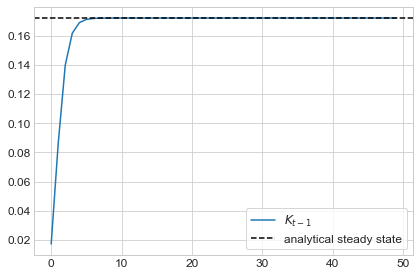

In [16]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.axhline(K_ss,ls='--',color='black',label='analytical steady state') # <-- plot analytical to compare with simulation
ax.legend(frameon=True)
fig.tight_layout()
K_lag_old = model.sim.K_lag.copy()

- as we converges to analytical steady state it seems as if the code works

**Task:** Test if the starting point matters?

**Additional check:** Not much should change with only small parameter changes. 

In [17]:
# a. production (close to cobb-douglas)
par.production_function = 'ces'
par.theta = 0.001

# b. household (close to logarithmic)
par.sigma = 1.1

# c. goverment (weakly active)
par.tau_w = 0.001
par.tau_r = 0.001

# d. simulate
model.simulate()

simulation done in 0.03 secs


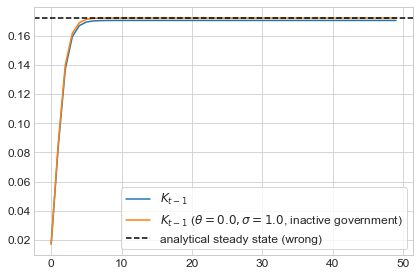

In [18]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.plot(K_lag_old,label=r'$K_{t-1}$ ($\theta = 0.0, \sigma = 1.0$, inactive government)')
ax.axhline(K_ss,ls='--',color='black',label='analytical steady state (wrong)')
ax.legend(frameon=True)
fig.tight_layout()

## Active government

In [19]:
model = OLGModelClass()
par = model.par
sim = model.sim

initializing the model:
calling .setup()
calling .allocate()


Use **baseline parameters** as defined in the module:

In [20]:
model.simulate()

simulation done in 0.03 secs


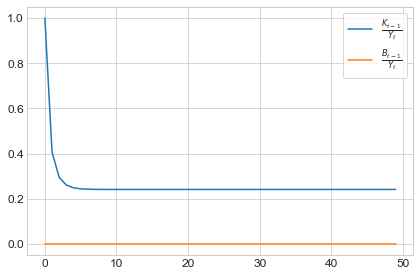

In [21]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(sim.K_lag/(sim.Y),label=r'$\frac{K_{t-1}}{Y_t}$')
ax.plot(sim.B_lag/(sim.Y),label=r'$\frac{B_{t-1}}{Y_t}$')
ax.legend(frameon=True)
fig.tight_layout()

- no amount of government bonds because of balanced budget

**Remember steady state:**

In [22]:
K_ss = sim.K_lag[-1]
B_ss = sim.B_lag[-1]
G_ss = sim.G[-1]

**Spending spree of 5% in $T=3$ periods:**

In [23]:
# a. start from steady state
par.K_lag_ini = K_ss
par.B_lag_ini = B_ss

# b. spending spree for 3 periods
T0 = 0
dT = 3
sim.G[T0:T0+dT] = 1.05*G_ss
sim.balanced_budget[:T0] = True #G adjusts
sim.balanced_budget[T0:T0+dT] = False # B adjusts
sim.balanced_budget[T0+dT:] = True # G adjusts

**Simulate:**

In [24]:
model.simulate()

simulation done in 0.03 secs


**Crowding-out of capital:**

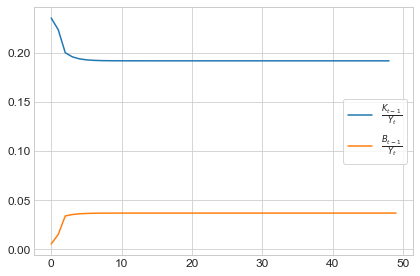

In [25]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(sim.K/(sim.Y),label=r'$\frac{K_{t-1}}{Y_t}$')
ax.plot(sim.B/(sim.Y),label=r'$\frac{B_{t-1}}{Y_t}$')
ax.legend(frameon=True)
fig.tight_layout()

- crowding out effect. E.g. spend more money on military and because household holds government debt instead of capital we have depreciation of capital.

**Question:** Would the households react today if the spending spree is say 10 periods in the future? 

In [26]:
# a. start from steady state
par.K_lag_ini = K_ss
par.B_lag_ini = B_ss

# b. spending spree for 3 periods
T0 = 10
dT = 3
sim.G[T0:T0+dT] = 1.05*G_ss
sim.balanced_budget[:T0] = True #G adjusts
sim.balanced_budget[T0:T0+dT] = False # B adjusts
sim.balanced_budget[T0+dT:] = True # G adjusts

In [27]:
model.simulate()

simulation done in 0.03 secs


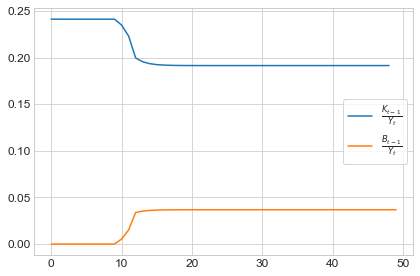

In [28]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(sim.K/(sim.Y),label=r'$\frac{K_{t-1}}{Y_t}$')
ax.plot(sim.B/(sim.Y),label=r'$\frac{B_{t-1}}{Y_t}$')
ax.legend(frameon=True)
fig.tight_layout()

- NO reaction because households only live for two periods (young/old) and this happens 10 periods out they don't take that into account

## Getting an overview

## Potential analysis and extension

**Potential analysis:**

1. Over-accumulation of capital relative to golden rule?
2. Calibration to actual data
3. Generational inequality
4. Multiple equilibria

**Extensions:**

1. Add population and technology growth
2. More detailed tax and transfer system
3. Utility and productive effect of government consumption/investment
4. Endogenous labor supply
5. Bequest motive
6. Uncertain returns on capital
7. Additional assets (e.g. housing)
8. More than two periods in the life-cycle (life-cycle)
9. More than one dynasty (cross-sectional inequality dynamics)

# Ramsey model (Ramsey-Cass-Koopman Model)

## Model descripton

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics::** Population is constant. Everybody lives forever as opposed to OLG.

**Household:** Households supply labor exogenously, $L_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. Utility is 

$$
\begin{aligned}
U & =\max_{\{C_{t}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}\frac{C_{t}^{1-\sigma}}{1-\sigma},\beta\in(0,1),\sigma>0\\
 & \text{s.t.}\\
 & M_{t}=(1+r_{t})N_{t-1}+w_{t}\\
 & N_{t}=M_{t}-C_{t}
\end{aligned}
$$

where $M_{t}$ is cash-on-hand and $N_{t}$ is end-of-period assets.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}= F(K_{t-1},E_{t})=A_t(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1),A_t>0
\end{aligned}
$$

Profits are

$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. Labor market clear: $E_{t}=L_{t}=1$
4. Goods market clear: $Y_{t}=C_{t}+I_{t}$
5. Asset market clear: $N_{t}=K_{t}$ and $r_{t}=r_{t}^{k}-\delta$
6. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Implication of profit maximization:** From FOCs


\begin{aligned}
r_{t}^{k} & = F_{K}(K_{t-1},E_{t})=A_t \alpha K_{t-1}^{-\theta-1}Y_{t}^{-1}\\
w_{t} & = F_{E}(K_{t-1},E_{t})=A_t (1-\alpha)E_{t}^{-\theta-1}Y_{t}^{-1}
\end{aligned}


**Implication of utility maximization:** From FOCs
\begin{equation}
\mathcal{L}=\sum_{t=0}^{\infty} \beta^{t} \frac{c_{t}^{1-\sigma}}{1-\sigma}+\sum_{t=0}^{\infty} \lambda_t\left[\left(1+r_{t}\right) N_{t-1}+w_{t}-c_{t}-N_{t}\right]
\end{equation}
$t=0$:
\begin{equation}
\frac{\partial L}{\partial c_{t}}=0 \Leftrightarrow \beta^{0} \cdot \frac{1-\sigma}{1-\sigma} \cdot c_{t}^{-\sigma}-\lambda_{t}=0
\end{equation}
$t=1$:
\begin{equation}
\frac{\partial L}{\partial N_{t+1}}=0 \Leftrightarrow-\lambda_{t}+\lambda_{t+1}\left(1+r_{t+1}\right)=0
\end{equation}

We know $\lambda_{t}=\beta^{0} \cdot \frac{1-\sigma}{1-\sigma} \cdot c_{t}^{-\sigma}$ implies: 
$$
\lambda_{t+1}=\beta^{0} \cdot \frac{1-\sigma}{1-\sigma} \cdot c_{t+1}^{-\sigma}
$$
Such that we get:
\begin{aligned}
C_{t}^{-\sigma}=\beta(1+r_{t+1})C_{t+1}^{-\sigma}
\end{aligned}

**Solution algorithm:** 

We can summarize the model in the **non-linear equation system**

$$
\begin{aligned}
\boldsymbol{H}(\boldsymbol{K},\boldsymbol{C},K_{-1})=\left[\begin{array}{c}
H_{0}\\
H_{1}\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]=\left[\begin{array}{c}
0\\
0\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]
\end{aligned}
$$

where we have capital and consumption in all future period $\boldsymbol{K} = [K_0,K_1\dots]$, $\boldsymbol{C} = [C_0,C_1\dots]$, and

$$
\begin{aligned}
H_{t}
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+r_{t+1})C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1}+Y_t-C_{t}]
\end{array}\right]
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+F_{K}(K_{t},1))C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1} + F(K_{t-1},1)-C_{t}])
\end{array}\right]
\end{aligned}
$$
where each H is the error in the Euler equation and the error in the law of motion for capital.\
**Path:** We refer to $\boldsymbol{K}$ and $\boldsymbol{C}$ as *transition paths*.

## Implementation
**Implementation:** We solve this equation system in **two steps**:

1. Assume all variables are in steady  state after some **truncation horizon** (as we want to have t-dimensional vectors).
1. Calculate the numerical **jacobian** of $\boldsymbol{H}$ wrt. $\boldsymbol{K}$
and $\boldsymbol{C}$ around the steady state
2. Solve the equation system using a **hand-written Broyden-solver** (finding roots)

**Note:** The equation system can also be solved directly using `scipy.optimize.root`.

**Recap Jacobian**: 
- The jacobian is just a gradient (partial derivative of every variable in H against very function in H). I.e. the matrix of what the implied errors are in $\boldsymbol{H}$ when a *single* $K_t$ or $C_t$ change.
- describes how a local change to the input changes the output

$$\mathbf{J}=\left[\begin{array}{ccc}\frac{\partial \mathbf{f}}{\partial x_{1}} & \cdots & \frac{\partial \mathbf{f}}{\partial x_{n}}\end{array}\right]=\left[\begin{array}{c}\nabla^{\mathrm{T}} f_{1} \\ \vdots \\ \nabla^{\mathrm{T}} f_{m}\end{array}\right]=\left[\begin{array}{ccc}\frac{\partial f_{1}}{\partial x_{1}} & \cdots & \frac{\partial f_{1}}{\partial x_{n}} \\ \vdots & \ddots & \vdots \\ \frac{\partial f_{m}}{\partial x_{1}} & \cdots & \frac{\partial f_{m}}{\partial x_{n}}\end{array}\right]$$

Newton's method would calculate the Jacobian for each iteration, however it is computationally expensive. Instead, Broyden's only compute the jacobian only at the first iterations and then update the Jacobian based on new information.

***A.Initial guess*** (here we are applying Newton's method)
$$
\boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - \boldsymbol{J_n}^{-1}\boldsymbol{f}_{n}
$$

Evaluate if function is zero
$$
\boldsymbol{f}_{n}(\boldsymbol{x}) = \boldsymbol{0}
$$
using tolerance criteria `np.max(np.abs(y)) < tol =1e-8`

***B. iterate***

1. If $\boldsymbol{f}_{n}(\boldsymbol{x}) \ne \boldsymbol{0}$ given some tolerance update $x$: 
$$\Delta\boldsymbol{x_n} = -\boldsymbol{J_n}^{-1}\boldsymbol{f}_{n} \Leftrightarrow \boldsymbol{J}dx=-\boldsymbol{f}_{n}$$
has converged using `np.linalg.solve(Jac,-y)`

2. Evaluate if function:
$$
\boldsymbol{f}_{n}(\boldsymbol{x+\Delta{x}}) = \boldsymbol{0}
$$
using tolerance criteria `np.max(np.abs(y)) < tol =1e-8`

3. Update Jac
$$
\Delta\boldsymbol{f_n} = \boldsymbol{f}_{n} - \boldsymbol{f}_{n-1} \\
\boldsymbol{J}_n = \boldsymbol{J}_{n-1} + \frac{\Delta \mathbf{f}_{n}-\mathbf{J}_{n-1} \Delta \mathbf{x}_{n}}{\left\|\Delta \mathbf{x}_{n}\right\|^{2}} \Delta \mathbf{x}_{n}^{\mathrm{T}}
$$
*note we take the outer product on second term on the r.h.s using `np.outer(((dy - jac @ dx) / np.linalg.norm(dx)**2), dx)`*

Now set 
$ \boldsymbol{f}_{n} = \boldsymbol{f}_{n-1}$ $\&$ $\boldsymbol{x} = \boldsymbol{x} + \Delta \boldsymbol{x} $
and repeat Steps from B.1 to B.3 until tolerance criteria is satisfied. 

## Structure of the code - Ramsey
1. Create model
    - `namespace()` to contain information on model
    - call setup 
    - call allocate
2. Find Steady state
3. Evaluate path errors
    - using production function 
4. calculate Jacobian 
    - using step 3
5. Solve
    - using step 3 
    - handwritten broyden
        - uses step 4

## Solution

**Setup the model**

In [5]:
model = RamseyModelClass()
# our namespaces
par = model.par
ss = model.ss
path = model.path

initializing the model:
calling .setup()
calling .allocate()


**Find steady state:** 

1. Target steady-state capital-output ratio, $K_{ss}/Y_{ss}$ of 4.0.
2. Force steady-state output $Y_{ss} = 1$.
3. Adjust $\beta$ and $A_{ss}$ to achieve this.

In [6]:
model.find_steady_state(KY_ss=4.0)

Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
A = 0.6598
beta = 0.9756


**Test that errors and the path are 0:**

In [7]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.A[:] = ss.A # set input to stead state
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors() 
assert np.allclose(errors_ss,0.0) # <-- check all are zeros

In [8]:
#errors_ss

**Intermezzo** Say technology is 10% higher in first 5 periods we get an error:

In [9]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.A[:5] = 1.1 # set input to stead state
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors() 
assert np.allclose(errors_ss,0.0) # <-- check all are zeros

AssertionError: 

Calculate numerical derivatives

In [10]:
#errors_ss

In [11]:
model.calculate_jacobian()

Effect on c:

In [12]:
amodel.jac[:5,0] # looking at first 5 variables and shock to the first one

array([-3.90624268,  0.        ,  0.        ,  0.        ,  0.        ])

In [13]:
model.jac[:5,1]

array([ 4.09696875, -3.90624268,  0.        ,  0.        ,  0.        ])

In [14]:
model.jac[:5,2]

array([ 0.        ,  4.09696875, -3.90624268,  0.        ,  0.        ])

Because c turns up in two periods cf. our H it has this effect.

Effect on K from differentiating wrt. K:

In [20]:
model.jac[par.Tpath:par.Tpath+5,par.Tpath+0] # <-- model.jac[500:505,500]

array([ 1.        , -1.07504661,  0.        ,  0.        ,  0.        ])

In line with the equation for K in error where the 1 is actually the derivative of of the K. 

**Solve:**

In [27]:
# Change back
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.A[:] = ss.A # set input to stead state
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors() 
assert np.allclose(errors_ss,0.0) # <-- check all are zeros

In [28]:
# change back
model.calculate_jacobian()

In [29]:
par.K_lag_ini = 0.50*ss.K # start away from steady state
model.solve() # find transition path

 it =   0 -> max. abs. error =   2.08774760
 it =   1 -> max. abs. error =   0.03407048
 it =   2 -> max. abs. error =   0.04084472
 it =   3 -> max. abs. error =   0.00495803
 it =   4 -> max. abs. error =   0.01354190
 it =   5 -> max. abs. error =   0.01209108
 it =   6 -> max. abs. error =   0.00397825
 it =   7 -> max. abs. error =   0.00192043
 it =   8 -> max. abs. error =   0.00097483
 it =   9 -> max. abs. error =   0.00009018
 it =  10 -> max. abs. error =   0.00010485
 it =  11 -> max. abs. error =   0.00000476
 it =  12 -> max. abs. error =   0.00000737
 it =  13 -> max. abs. error =   0.00000045
 it =  14 -> max. abs. error =   0.00000038
 it =  15 -> max. abs. error =   0.00000002
 it =  16 -> max. abs. error =   0.00000002
 it =  17 -> max. abs. error =   0.00000000


**Plot transition path**

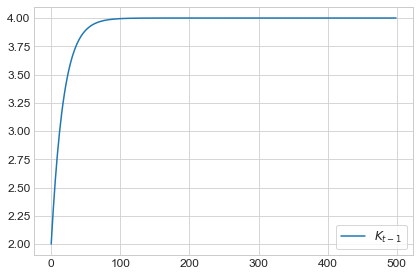

In [30]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()

## Comparison with scipy solution

**Note:** scipy computes the jacobian internally

In [118]:
model_scipy = RamseyModelClass()
model_scipy.par.solver = 'scipy'
model_scipy.find_steady_state(KY_ss=4.0)
model_scipy.par.K_lag_ini = 0.50*model_scipy.ss.K
model_scipy.path.A[:] = model_scipy.ss.A
model_scipy.solve()

initializing the model:
calling .setup()
calling .allocate()
Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
A = 0.6598
beta = 0.9756


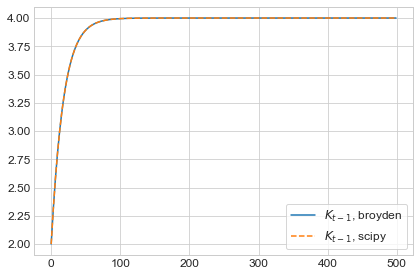

In [119]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$, broyden')
ax.plot(model_scipy.path.K_lag,ls='--',label=r'$K_{t-1}$, scipy')
ax.legend(frameon=True)
fig.tight_layout()

## Persistent technology shock

(MIT)-**Shock:**
We say raise 0.95 to increasing number times 10% of technoloy + s.s. technoloy

In [120]:
par.K_lag_ini = ss.K # start from steady state
path.A[:] = 0.95**np.arange(par.Tpath)*0.1*ss.A + ss.A # shock path

In [121]:
#path.A

**Terminology:** This is called an MIT-shock. Households do not expect shocks. Know the full path of the shock when it arrives. Continue to believe no future shocks will happen.

**Smart** thing is that we do not need to calculate the Jacobian again!

**Solve:**

In [122]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00096551
 it =   2 -> max. abs. error =   0.00004937
 it =   3 -> max. abs. error =   0.00000248
 it =   4 -> max. abs. error =   0.00000040
 it =   5 -> max. abs. error =   0.00000006
 it =   6 -> max. abs. error =   0.00000000


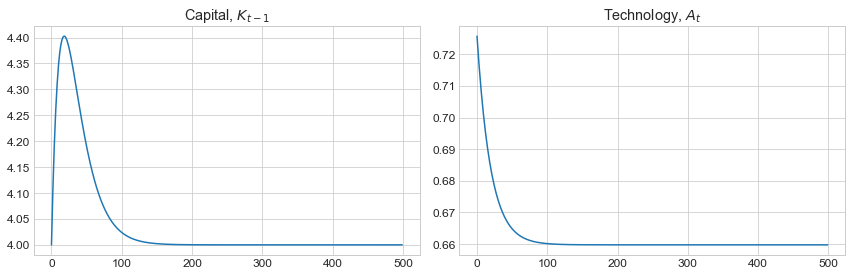

In [123]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.A)
ax.set_title('Technology, $A_t$')

fig.tight_layout()

Capital will increase as we get richer, but then we will spent it down again.

**Question:** Could a much more persistent shock be problematic?

## Future persistent technology shock

**Shock happing after period $H$:**

In [124]:
par.K_lag_ini = ss.K # start from steady state

# shock
H = 50
path.A[:] = ss.A
path.A[H:] = 0.95**np.arange(par.Tpath-H)*0.1*ss.A + ss.A

**Solve:**

In [125]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00267237
 it =   2 -> max. abs. error =   0.00015130
 it =   3 -> max. abs. error =   0.00000241
 it =   4 -> max. abs. error =   0.00000025
 it =   5 -> max. abs. error =   0.00000002
 it =   6 -> max. abs. error =   0.00000000


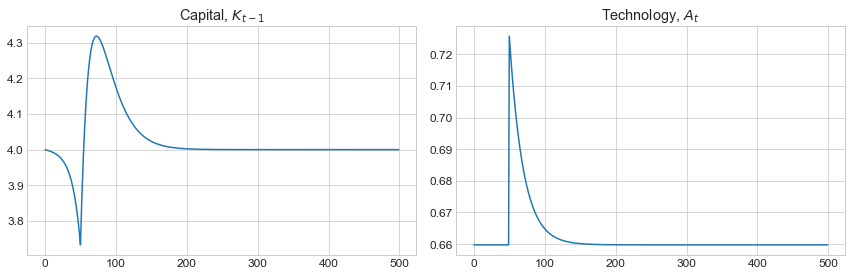

In [126]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.A)
ax.set_title('Technology, $A_t$')

fig.tight_layout()

**Take-away:** Households are forward looking and responds before the shock hits by consuming more, because they know they will get richer after period 50.

**Surprising the households**

In [127]:
K_lag = path.K_lag.copy()

In [128]:
par.K_lag_ini = path.K[30]
path.A[:] = ss.A
model.solve()

 it =   0 -> max. abs. error =   0.05301739
 it =   1 -> max. abs. error =   0.00001569
 it =   2 -> max. abs. error =   0.00000010
 it =   3 -> max. abs. error =   0.00000000


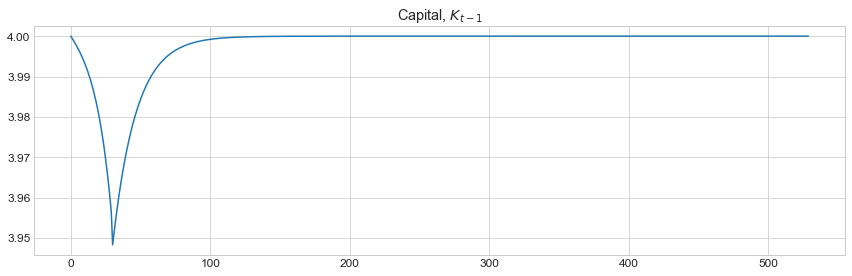

In [129]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(np.append(K_lag[:30],path.K_lag))

fig.tight_layout()

## Potential analysis and extension

**Potential analysis:**

1. Different shocks (e.g. discount factor)
2. Multiple shocks
3. Permanent shocks ($\rightarrow$ convergence to new steady state)
4. Transition speed

**Extensions:**

1. Add a government and taxation
2. Endogenous labor supply
3. Additional assets (e.g. housing)
4. Add nominal rigidities (New Keynesian), money holdings, and a central bank
5. uncertainties and shocks
6. international trade and open economies
7. demography

# Further perspectives

**The next steps beyond this course:** 

1. The **Bewley-Huggett-Aiyagari** model. A multi-period OLG model or Ramsey model with households making decisions *under uncertainty and borrowing constraints* as in lecture 11 under "dynamic optimization". Such heterogenous agent models are used in state-of-the-art research, see [Quantitative Macroeconomics with Heterogeneous Households](https://www.annualreviews.org/doi/abs/10.1146/annurev.economics.050708.142922). 

2. Further adding nominal rigidities this is called a **Heterogenous Agent New Keynesian (HANK)** model. See [Macroeconomics with HANK models](https://drive.google.com/file/d/16Qq7NJ_AZh5NmjPFSrLI42mfT7EsCUeH/view).

3. This extends the **Representative Agent New Keynesian (RANK)** model, which itself is a Ramsey model extended with nominal rigidities. 

4. The final frontier is including **aggregate risk**, which either requires linearization or using a **Krussell-Smith method**. Solving the model in *sequence-space* as we did with the Ramsey model is a frontier method (see [here](https://github.com/shade-econ/sequence-jacobian/#sequence-space-jacobian)).



